In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import skimage.io 
import cv2 
# import scipy convolve 
from scipy.signal import convolve2d

## *2.1 Exercise in scale-space blob detection*

In this exercise you will implement scale-space blob detection to detect and measure glass fibres from images of a glass fibre composite. An image example in Figure **2.1** shows a polished surface of a glass fibre composite sample, where individual fibres can be seen. Since these fibres are relatively circular we will model them as circles. This means that we must find their position (center coordinate) and diameter, and for this we will use the scale-space blob detection. After having computed the fibres parameters, we will carry a statistical analysis of the results.

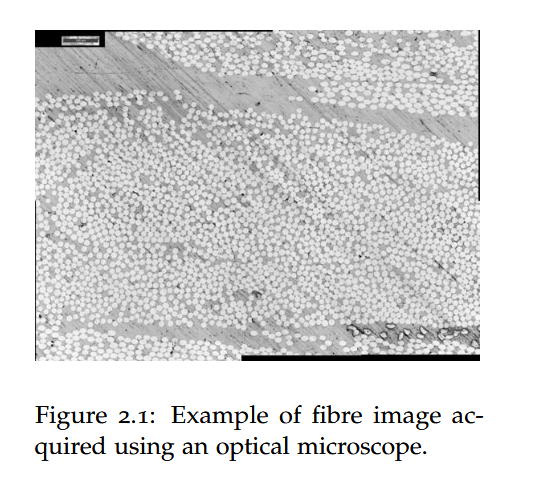

### *2.1.1 Computing Gaussian and its second order derivative*

We will approach this analysis in steps that lead to the final algorithm. First we will use synthetic data to develop and test our algorithm, and after that we will carry out the analysis on the real images.

Since we focus on blob detection, we must have a Gaussian kernel and its second order derivative. Some convolution libraries have already implemented the second order derivative of a Gaussian that you are welcome to use for the exercise. But we will here assume that you need to implement the kernel yourself.

The Gaussian is separable and we can always employ 1D filters, both for the Gaussian, and its derivatives. The 1D Gaussian is given by

$$
g(x) = \frac{1}{\sqrt{2\pi t}} e^{-\frac{x^2}{2t}}. \tag{2.5}
$$

_____

#### *Suggested procedure*

1. Derive (analytically) the second order derivative of the Gaussian

   $$
   \frac{d^2 g}{dx^2}.
   $$


Assume $\mu = 0$ for simplicity (or at least we have done the previous centered around 0)

The Gaussian function is given by:

$$g(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}$$


To differentiate $g(x)$ \), I first pull out the constant:

$$g'(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \frac{d}{dx} \bigg[ e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)} \bigg]$$


Using the chain rule:


$$g'(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\frac{d}{dx} e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
= e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)} \cdot \frac{d}{dx} \left( -\frac{1}{2} \frac{x^2}{\sigma^2} \right)$$

Differentiating the exponent:

$$\frac{d}{dx} \left( -\frac{1}{2} \frac{x^2}{\sigma^2} \right) = -\frac{2x}{2\sigma^2} = -\frac{x}{\sigma^2}$$

Putting it all together gives:

$$g'(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot \left( -\frac{x}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}$$



Now so I don't need to write the constant around I let $c = \frac{1}{\sqrt{2\pi\sigma^2}}$ and write:


$$g'(x) = c \left( -\frac{x}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}$$

Now, differentiating again and using the product rule:


$$g''(x) = c \left[ \frac{d}{dx} \left( -\frac{x}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
+ \left( -\frac{x}{\sigma^2} \right) \frac{d}{dx} e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}\right]$$

The first term:


$$\frac{d}{dx} \left( -\frac{x}{\sigma^2} \right) = -\frac{1}{\sigma^2}$$

Which is now:

$$ \left( -\frac{1}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}$$

For the second term, using the chain rule again:


$$\frac{d}{dx} e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
= e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)} \cdot \frac{d}{dx} \left( -\frac{1}{2} \frac{x^2}{\sigma^2} \right)
$$

$$
= e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)} \left( -\frac{x}{\sigma^2} \right)
$$

And I obtain:

$$
\left( -\frac{x}{\sigma^2} \right) \left( -\frac{x}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
= \left( \frac{x^2}{\sigma^4} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
$$

Finally putting it all together and factoring out the exponential term:

$$
g''(x) = c \left[ \left( -\frac{1}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
+ c \left( \frac{x^2}{\sigma^4} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}\right]
$$

$$
= c \left( \frac{x^2}{\sigma^4} - \frac{1}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
$$

Rewriting the constant:

$$
g''(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \left( \frac{x^2}{\sigma^4} - \frac{1}{\sigma^2} \right) e^{-\frac{1}{2} \left( \frac{x^2}{\sigma^2} \right)}
$$

____

2. Implement a function that takes the variance $t$ as input and outputs a filter kernel of $g$ and $\frac{d^2 g}{dx^2}$. You should use a filter kernel with a size of at least $\pm 3\sqrt{t}$. Why? (*Hint:* Set a variable $r = \lceil 3\sqrt{t} \rceil$, make an array with the integer values $[-r, \dots, r]$ and compute the Gaussian on these values.)



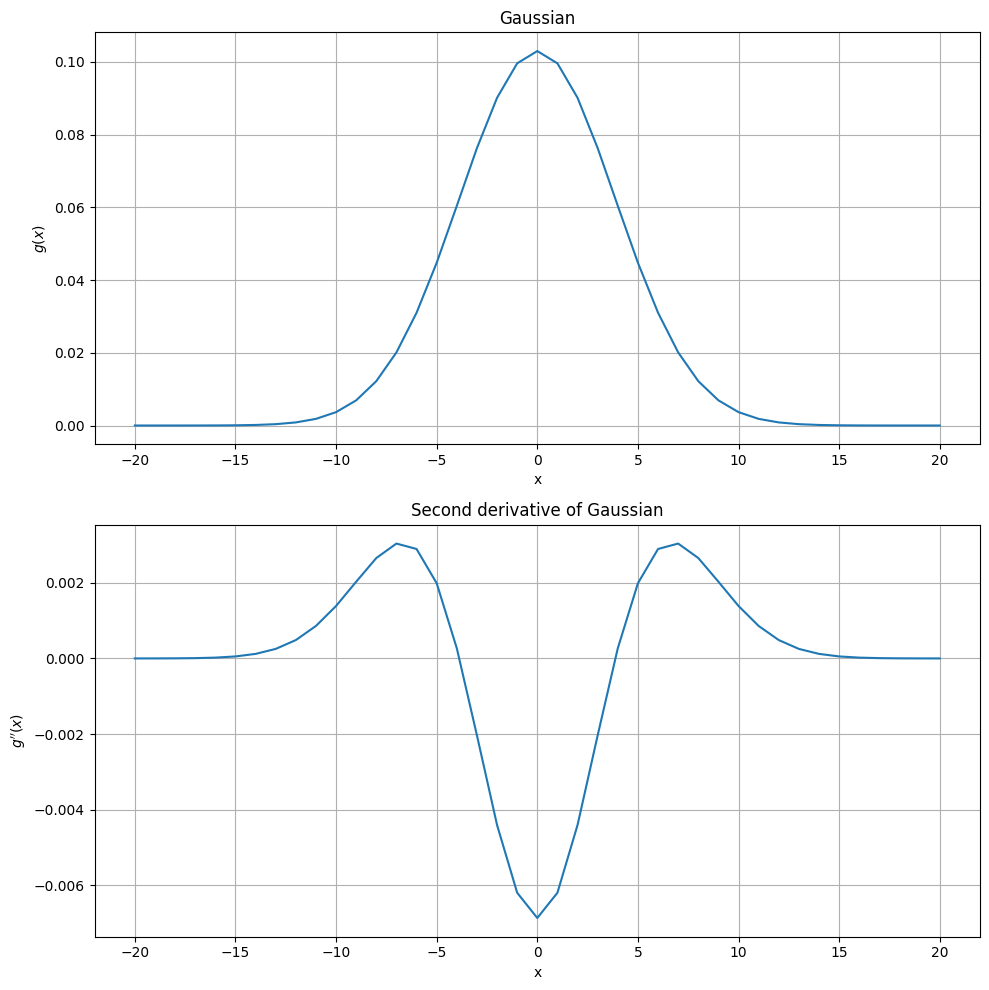

In [5]:
t = 15 

sigma = np.sqrt(t)
s = np.ceil(5*sigma)
x = np.arange(-s, s+1)

g = 1/(sigma*np.sqrt(2 * np.pi)) * np.exp(-x**2/(2*t))

g_dif_2 = g * (x**2 - sigma**2) / sigma**4

# fig with 2 subplots

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(x, g)
axs[0].set_title('Gaussian')
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$g(x)$')
axs[0].grid()

axs[1].plot(x, g_dif_2)
axs[1].set_title('Second derivative of Gaussian')
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$g^{\prime\prime}(x)$')
axs[1].grid()

plt.tight_layout()
plt.show()


In [10]:
def filter_second_der_filter(t):
    sigma = np.sqrt(t)
    s = np.ceil(5*sigma)
    x = np.arange(-s, s+1)

    g = 1/(sigma*np.sqrt(2 * np.pi)) * np.exp(-x**2/(2*t))

    g_dif_2 = g * (x**2 - sigma**2) / sigma**4

    return g, g_dif_2, x

In [11]:
g_kernel, g_dif_2_kernel, x = filter_second_der_filter(15)

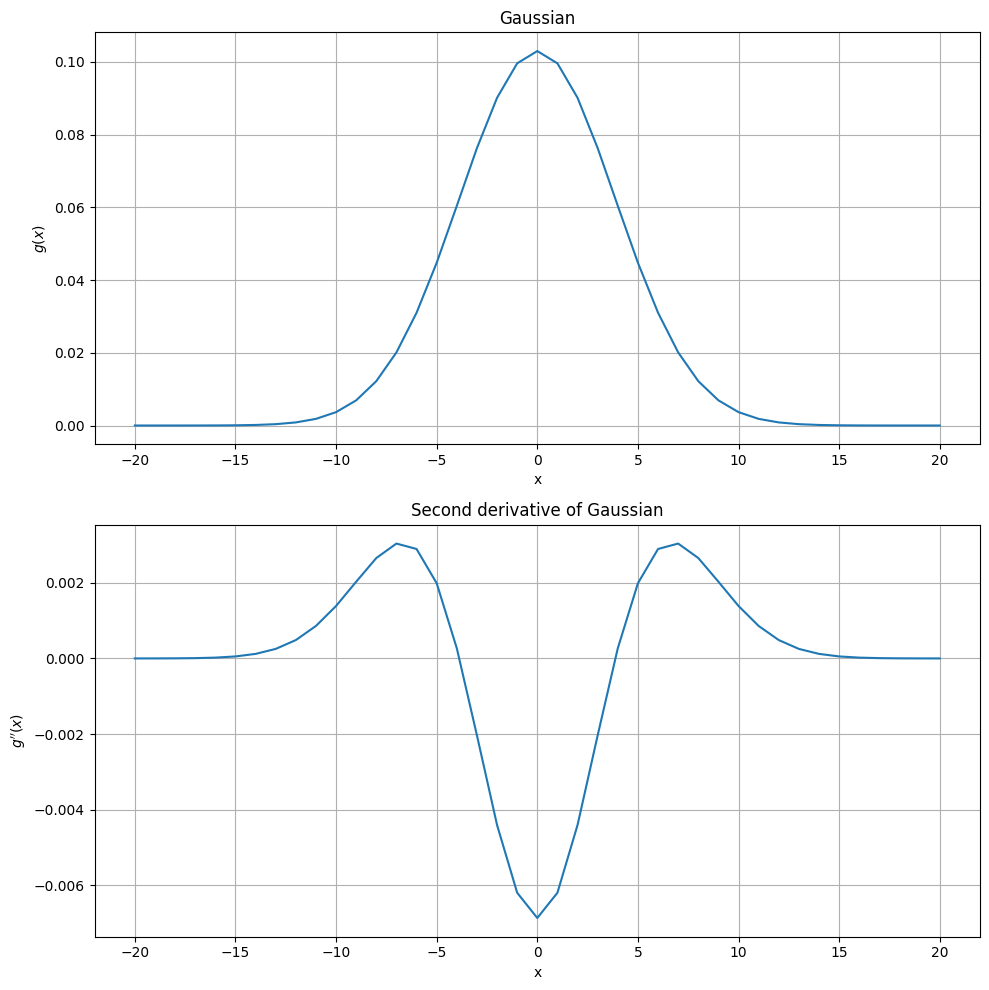

In [12]:
# visualize the kernels

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(x, g_kernel)
axs[0].set_title('Gaussian')
axs[0].set_xlabel('x')
axs[0].set_ylabel(r'$g(x)$')
axs[0].grid()

axs[1].plot(x, g_dif_2_kernel)
axs[1].set_title('Second derivative of Gaussian')
axs[1].set_xlabel('x')
axs[1].set_ylabel(r'$g^{\prime\prime}(x)$')
axs[1].grid()

plt.tight_layout()
plt.show()


3. Try the filter kernel on the synthetic test image `test_blob_uniform.png` and inspect the result.

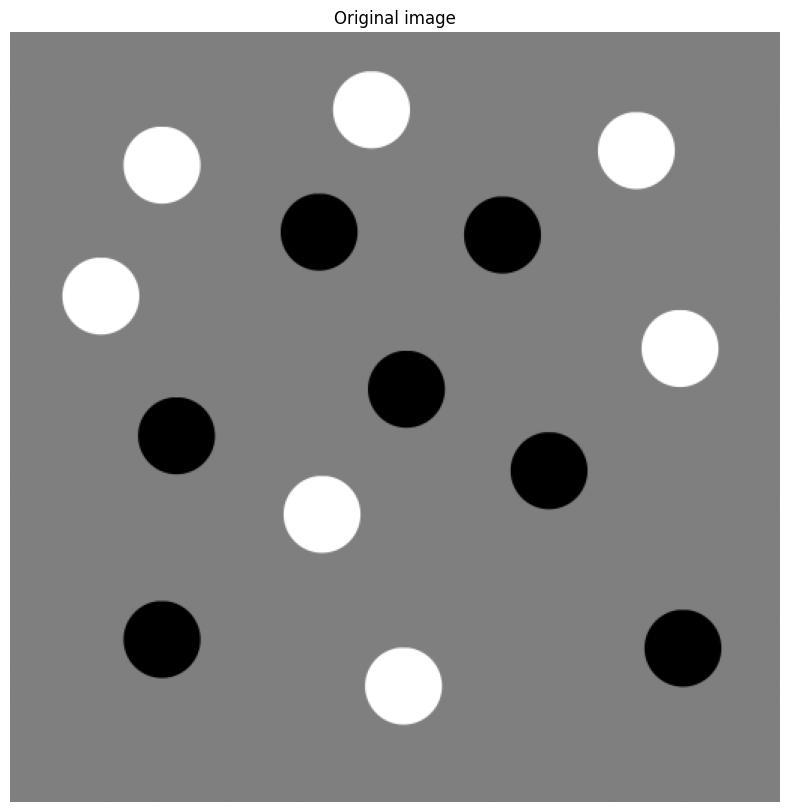

In [19]:
image = skimage.io.imread('data/test_blob_uniform.png').astype(float)

# visualize the iamge 
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.show()


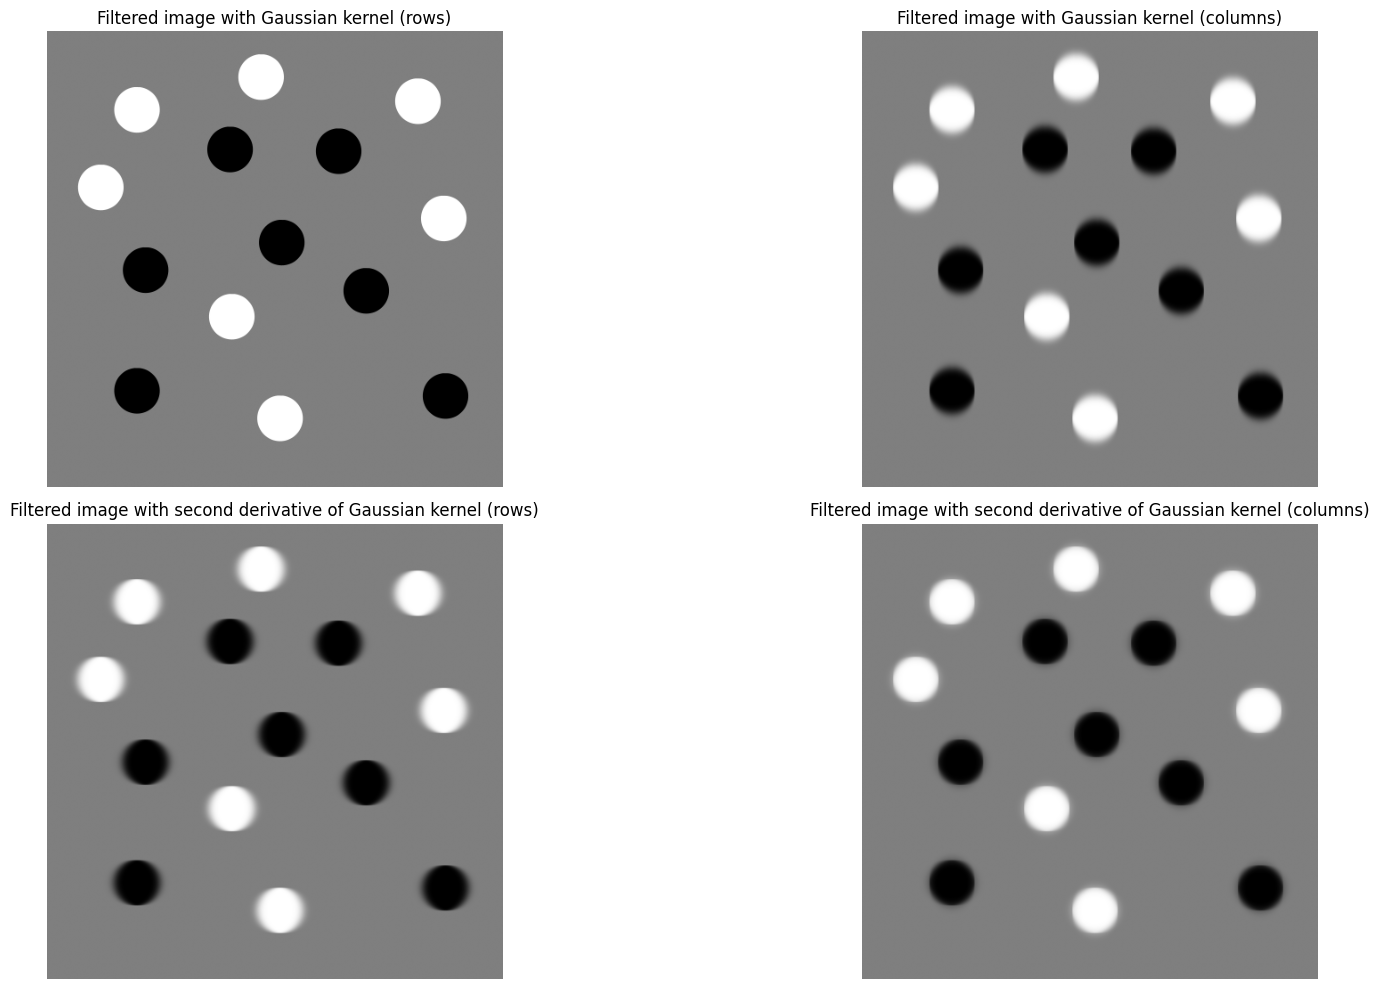

In [22]:
# define a new 1D kernel 

kernel, kernel_dif_2, _ = filter_second_der_filter(20)

# reshape the kernel to a column vector and row vector


image_blured = cv2.filter2D(image, -1, kernel=kernel.reshape(-1, 1))

image_blured_2 = cv2.filter2D(image, -1, kernel=kernel.reshape(1, -1))



image_added = image_blured + image_blured_2

# visualize the filtered image and original 

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0][0].imshow(image, cmap='gray')
axs[0][0].axis('off')
axs[0][0].set_title('Filtered image with Gaussian kernel (rows)')

axs[0][1].imshow(image_blured, cmap='gray')
axs[0][1].axis('off')
axs[0][1].set_title('Filtered image with Gaussian kernel (columns)')

axs[1][0].imshow(image_blured_2, cmap='gray')
axs[1][0].axis('off')
axs[1][0].set_title('Filtered image with second derivative of Gaussian kernel (rows)')
axs[1][1].imshow(image_added, cmap='gray')
axs[1][1].axis('off')
axs[1][1].set_title('Filtered image with second derivative of Gaussian kernel (columns)')
#plt.savefig('data/filtered_image.png')
plt.tight_layout()
plt.show()
